# Stanford Law School: Analyzing Financial Memes Using Data Science

By Zach Lefkovitz (in coordination with Graham Ambrose, Stanford Law School).

09/12/2023

## Introduction

### Special Purpose Acquisition Companies

Special Purpose Acquisition Companies (SPACs) are companies created solely for the purpose of raising capital through an initial public offering (IPO) with the intention of acquiring an existing private company and taking it public. SPACs are also known as "blank check" companies, as they have no operations or business activities at the time of their IPO. SPACs are highly criticized for over selling their companies assets and being a method of enriching insiders.

### An Opportunity is Presented

![Stanford Law School](assets/sls-social-default.jpg)

Graham Ambrose is a law student at Stanford Law School and the older brother of my good high school friend, Zac. This winter break, Zac reached out to me because Graham was looking for a computer scientist to help assist him with a data science project for his research on SPACs. Not wanting to pass on an opportunity to get my name in law review, I accepted the opportunity and began to message Graham.

### Professor Klausner

Graham does research for [Professor Michael Klausner](https://law.stanford.edu/directory/michael-klausner/). Klasuner teachers and writer for the Stanford Nancy and Charles Munger School of Business and Stanford Law School. His special research area is in Banking and Financial Institutions, Business & Corporate Law, and Capital Markets. His 2020 publication, *A Sober Look at SPACs,* has been cited by the SEC in proposing regulation to the industry and he is currently suing three SPACs in Delaware Court.

### Research Purpose

![Wall Street Bets](assets/WallStreetBets.png)

In his research, Graham wanted to explore when and why SPACs became so popular. Through platforms like Twitter and Reddit's r/WallStreetBets, SPACs became a financial meme. Using data science, Graham wanted to know exactly when SPACs started becoming popular. SPACs have been financial tools since the 90s but he hypothesizes there's been a sharp increase in the use of SPACs in public knowledge starting in 2020. 

### Limitations

![Translation of SPAC](assets/spac-translation.png)

Since Twitter was a popular platform for the promoting and growing of SPACs as a financial meme, it would seem intuitive to scrape twitter content that contain the word "SPAC" for our data. However the word "spac" means "to sleep" in Polish so it would make analysis more complicated. While it would be possible to use an algorithm to determine the tweet was in English or Polish to filter the data, instead we decided to use New York Times articles as a measure of the prevalence of SPACs in public discourse.

---

# Data Collection

To collect the data, we are going to use the New York Times API. This API can be found by Googling "New York Times API" are going to the URL https://developer.nytimes.com/.

## Creating an App

After creating a developer account with the New York Times, we need to create an app in order to obtain our API key. Under the accounts section on the top right, click on "apps" > Create New App. I created a new app called "NYT SPAC Analysis" and enabled the article search API.

![Create New App](assets/nyt/new-app.png)

Once the app is created, I copied my public and secret key and saved it to a .env file in my project's root directory. My .env file follows this format:
```
NYT_API_KEY=<YOUR API KEY>
NYT_SECRET_KEY=<YOUR SECRET KEY>
```

In the later parts of the project, I'll load the environment variables from that .env file into my python script.

## Exploring the Article Search API

The New York Times provides documentation for all their API endpoints. For the purpose of this project, we are going to use the article search API. The article search API allows NYT article look ups by keywords. The documentation can be found here: https://developer.nytimes.com/docs/articlesearch-product/1/overview.

From the NYT Article Search API documentation, here is an example API url:

```https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey```

Breaking down the url into its components:
* `https://api.nytimes.com/svc/search/v2/articlesearch.json`: The base url for the article search API
* `?q=election`: Query for the keyword "election" in NYT articles
* `api-key=yourkey`: Dedicated keyword to provide your API key to authenticate the API

Some other useful query parameters useful for us:
* `sort` = "newest" | "oldest" | "relevance": Sort the API results by chronologically or by relevance. Sorting chronologically will be nice for graphing the data in time series.
* `page` = number: The API results are paginated with a max of 10 pages, meaning that to get all results that contain the SPAC keyword, we'll have to exhaust all pages.

Formatting this API url to do a search for articles that include the word "SPAC" we get this URL

```https://api.nytimes.com/svc/search/v2/articlesearch.json?q=SPAC&sort=oldest&page=1&api-key=yourkey```

## Data Collection

In [123]:
import requests
import os
from dotenv import load_dotenv
import json
import datetime as dt
import pandas as pd
import seaborn as sns
import numpy as np

load_dotenv()

True

In [52]:
def article_search_by_keyword(keyword: str, api_key: str, page=1): 
    """Query the NYT article search API by keyword and return the response as a JSON object.
    
    @return None, Response: if the request fails
    @return JSON object, Response: if the request succeeds
    """
    url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?q=%s&page=%d&sort=newest&api-key=%s" % (keyword, page, api_key)
    res = requests.get(url)
    if res.status_code != 200 or res.json()['response']['docs'] == []:
        return None, res

    return res.json(), res

In [64]:
json_res, _ = article_search_by_keyword("special purpose acquisition company", os.getenv("NYT_API_KEY"))
json_res

In [65]:
json_res["response"]["docs"][0]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for key in json_res['response']['docs'][0].keys():
    print(key, type(json_res['response']['docs'][0][key]), sep=':\t')

abstract <class 'str'>
web_url <class 'str'>
snippet <class 'str'>
lead_paragraph <class 'str'>
print_section <class 'str'>
print_page <class 'str'>
source <class 'str'>
multimedia <class 'list'>
headline <class 'dict'>
keywords <class 'list'>
pub_date <class 'str'>
document_type <class 'str'>
news_desk <class 'str'>
section_name <class 'str'>
subsection_name <class 'str'>
byline <class 'dict'>
type_of_material <class 'str'>
_id <class 'str'>
word_count <class 'int'>
uri <class 'str'>


In [57]:
import time

def get_all_articles_for_keyword(keyword: str, api_key: str, max_page=100, sleep_time_sec=6, start_page=1):
    """Query the NYT article search API by keyword and return all the responses as a list of JSON objects.
    
    @return Response, Page: The response and page number of the last request when the request eventually fails
    @return None: If the requests go past max_page
    """
    os_friendly_keyword = keyword.replace(" ", "_")

    # Make the /data/nyt directory if it doesn't exist
    if not os.path.exists("data/nyt/%s" % os_friendly_keyword):
        os.makedirs("data/nyt/%s" % os_friendly_keyword)

    for page in range(start_page, max_page + 1):
        json_res, res = article_search_by_keyword(keyword, api_key, page)
        if json_res is None:
            return res, page
        with open("data/nyt/%s/%s_%d.json" % (os_friendly_keyword, os_friendly_keyword, page), "w") as f:
            f.write(json.dumps(json_res))
        print("%s: Finished page %d for keyword %s" % (dt.datetime.now(), page, keyword))
        # Have to sleep for rate timing
        time.sleep(sleep_time_sec)
    

In [63]:
# This while loop will run until an API rate limit is exceeded or until max_page is reached

start_page = 1
while True:
    num_rate_limits = 0
    error_res, page = get_all_articles_for_keyword("special purpose acquisition company", os.getenv("NYT_API_KEY"), start_page=start_page, sleep_time_sec=10, max_page=300)
    if type(error_res) == bytes or error_res.status_code == 429:
        num_rate_limits += 1
        if num_rate_limits > 10:
            break
        start_page = page
        print("Rate limit exceeded, sleeping for 1 minute")
        time.sleep(60)


Rate limit exceeded, sleeping for 1 minute


KeyboardInterrupt: 

## Data Formatting

### Combine the JSON Files to one dataframe for each keyword

In [72]:
def json_to_df(data: dict):
    """Convert a JSON object from the NYT article search API to a pandas DataFrame.
    
    @return DataFrame: The DataFrame representation of the JSON object
    """
    return pd.DataFrame(data['response']['docs'])

In [76]:
with open("data/nyt/special_purpose_acquisition_company/special_purpose_acquisition_company_1.json", "r") as f:
    json_res = json.loads(f.read())
    df = json_to_df(json_res)

df.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,subsection_name,byline,type_of_material,_id,word_count,uri
0,The preliminary guidance applies to an alterna...,https://www.nytimes.com/2022/12/27/us/politics...,The preliminary guidance applies to an alterna...,WASHINGTON — The Treasury Department on Tuesda...,A,16,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Treasury Department Outlines Rules f...,"[{'name': 'subject', 'value': 'United States P...",2022-12-27T22:58:06+0000,article,Washington,U.S.,Politics,"{'original': 'By Jim Tankersley', 'person': [{...",News,nyt://article/51e3a268-3b89-50c2-b801-3a750baa...,600,nyt://article/51e3a268-3b89-50c2-b801-3a750baa...
1,There were fewer mergers and public listings t...,https://www.nytimes.com/2022/12/23/business/wa...,There were fewer mergers and public listings t...,The luxury travel bookings will be more subdue...,B,1,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'For Many Wall Street Bankers, This Y...","[{'name': 'subject', 'value': 'Banking and Fin...",2022-12-23T08:00:10+0000,article,Business,Business Day,NaN,"{'original': 'By Maureen Farrell, Lauren Hirsc...",News,nyt://article/eaabf5ae-6d5d-5663-b8e2-2fa46f64...,1321,nyt://article/eaabf5ae-6d5d-5663-b8e2-2fa46f64...
2,An I.R.S. policy requires the agency audit pre...,https://www.nytimes.com/interactive/2022/12/21...,An I.R.S. policy requires the agency audit pre...,An I.R.S. policy requires the agency audit pre...,NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Document: Report on the I.R.S. Manda...,"[{'name': 'subject', 'value': 'Trump Tax Retur...",2022-12-21T02:28:23+0000,multimedia,U.S.,U.S.,Politics,"{'original': None, 'person': [], 'organization...",Interactive Feature,nyt://interactive/e07fa384-7481-51b5-8d82-6a46...,0,nyt://interactive/e07fa384-7481-51b5-8d82-6a46...
3,"Chamath Palihapitiya, once a relentless cheerl...",https://www.nytimes.com/2022/12/07/business/ch...,"Chamath Palihapitiya, once a relentless cheerl...","Not long ago, Chamath Palihapitiya could be ca...",B,1,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'The ‘SPAC King’ Is Over It', 'kicker...","[{'name': 'persons', 'value': 'Palihapitiya, C...",2022-12-07T10:00:35+0000,article,Business,Business Day,NaN,"{'original': 'By Maureen Farrell', 'person': [...",News,nyt://article/26f371d9-968c-54e3-a955-cdbc8880...,1748,nyt://article/26f371d9-968c-54e3-a955-cdbc8880...
4,Yahoo’s chief executive sees the deal as a lon...,https://www.nytimes.com/2022/11/28/business/de...,Yahoo’s chief executive sees the deal as a lon...,Yahoo is deepening its push into digital adver...,B,3,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Yahoo Takes Minority Stake in Ad Net...,"[{'name': 'subject', 'value': 'Computers and t...",2022-11-28T11:00:08+0000,article,Business,Business Day,DealBook,{'original': 'By Lauren Hirsch and Benjamin Mu...,News,nyt://article/9cef1d89-b296-52aa-adc9-c75b69fc...,679,nyt://article/9cef1d89-b296-52aa-adc9-c75b69fc...


In [136]:
# Combine all the JSON files in the SPAC and the special_purpose_acquisition_company directories into their respective DataFrame

spac_df = pd.DataFrame()
for file in os.listdir("data/nyt/spac"):
    with open("data/nyt/spac/%s" % file, "r") as f:
        json_res = json.loads(f.read())
        spac_df = pd.concat([spac_df, json_to_df(json_res)]) 


spac_df.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name
0,The company’s top executive resigned after the...,https://www.nytimes.com/2021/06/14/business/lo...,The company’s top executive resigned after the...,"When Mary T. Barra, the chief executive of Gen...",A,1,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Lordstown, Truck Maker That Can’t Af...","[{'name': 'organizations', 'value': 'Lordstown...",2021-06-14T12:07:16+0000,article,Business,Business Day,"{'original': 'By Matthew Goldstein, Lauren Hir...",News,nyt://article/da4c9fa3-556e-5989-8b6f-9ec45506...,1406,nyt://article/da4c9fa3-556e-5989-8b6f-9ec45506...,NaN
1,How a powerful industry conquered the U.S. tax...,https://www.nytimes.com/2021/06/14/business/de...,How a powerful industry conquered the U.S. tax...,The $4.5 trillion buyout industry “has perfect...,NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Private Equity’s Biggest Tax Tactics...,"[{'name': 'subject', 'value': 'Federal Taxes (...",2021-06-14T11:23:32+0000,article,Business,Business Day,"{'original': 'By Andrew Ross Sorkin, Jason Kar...",News,nyt://article/b3308881-073f-5092-bd37-77f2a034...,1779,nyt://article/b3308881-073f-5092-bd37-77f2a034...,DealBook
2,These complex takeover vehicles serve an impor...,https://www.nytimes.com/2021/06/12/business/de...,These complex takeover vehicles serve an impor...,The DealBook newsletter delves into a single t...,B,3,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'In Defense of SPACs', 'kicker': 'dea...","[{'name': 'subject', 'value': 'Special Purpose...",2021-06-12T12:00:04+0000,article,Business,Business Day,"{'original': 'By Steven Davidoff Solomon', 'pe...",News,nyt://article/91942d03-2916-523f-8906-9b578f19...,997,nyt://article/91942d03-2916-523f-8906-9b578f19...,DealBook
3,Inside Silicon Valley’s 10-year quest to make ...,https://www.nytimes.com/2021/06/12/technology/...,Inside Silicon Valley’s 10-year quest to make ...,To hear more audio stories from publications l...,BU,1,The New York Times,[],"{'main': 'What Is a Flying Car?', 'kicker': No...","[{'name': 'subject', 'value': 'Flying Cars', '...",2021-06-12T09:00:30+0000,article,SundayBusiness,Technology,"{'original': 'By Cade Metz and Erin Griffith',...",News,nyt://article/d96f1acf-8d87-5298-969f-0af0b491...,2340,nyt://article/d96f1acf-8d87-5298-969f-0af0b491...,NaN
4,It’s been a blowout year for executive pay.,https://www.nytimes.com/2021/06/11/business/de...,It’s been a blowout year for executive pay.,Want to get the DealBook newsletter in your in...,NaN,NaN,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Behold the Highest-Paid C.E.O.s', 'k...","[{'name': 'subject', 'value': 'Executive Compe...",2021-06-11T11:55:35+0000,article,Business,Business Day,"{'original': 'By Andrew Ross Sorkin, Jason Kar...",News,nyt://article/2fad74da-fca3-54e4-9e46-90851df7...,1367,nyt://article/2fad74da-fca3-54e4-9e46-90851df7...,DealBook


In [137]:
verbose_spac_df = pd.DataFrame()
for file in os.listdir("data/nyt/special_purpose_acquisition_company"):
    with open("data/nyt/special_purpose_acquisition_company/%s" % file, "r") as f:
        json_res = json.loads(f.read())
        verbose_spac_df = pd.concat([verbose_spac_df, json_to_df(json_res)])

verbose_spac_df.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name
0,Article on report released by Small Business A...,https://www.nytimes.com/2005/02/22/business/bu...,Article on report released by Small Business A...,ARE small businesses actually getting all the ...,G,9,The New York Times,[],"{'main': 'Case of the Missing Set-Aside', 'kic...","[{'name': 'organizations', 'value': 'Small Bus...",2005-02-22T05:00:00+0000,article,Small Business,Business Day,"{'original': 'By Bernard Stamler', 'person': [...",News,nyt://article/bd7136af-4eab-51c7-83eb-85272fd1...,1041,nyt://article/bd7136af-4eab-51c7-83eb-85272fd1...,NaN
1,Article on win-win situation involving joint a...,https://www.nytimes.com/2005/02/20/nyregion/de...,Article on win-win situation involving joint a...,THE joint acquisition of more than a square mi...,WC,14,The New York Times,[],"{'main': 'In Somers, An Investment For Everyon...","[{'name': 'glocations', 'value': 'Somers (NY)'...",2005-02-20T05:00:00+0000,article,Westchester Weekly Desk,New York,"{'original': 'By Elsa Brenner', 'person': [{'f...",News,nyt://article/a4955910-dd79-55ad-b18c-e18ddba7...,1044,nyt://article/a4955910-dd79-55ad-b18c-e18ddba7...,NaN
2,"Profile of Jane Friedman, chief executive of H...",https://www.nytimes.com/2005/02/06/business/yo...,"Profile of Jane Friedman, chief executive of H...",Correction Appended,3,1,The New York Times,[],{'main': 'Michael Crichton? He's Just the Auth...,"[{'name': 'organizations', 'value': 'NEWS CORP...",2005-02-06T05:00:00+0000,article,SundayBusiness,Books,"{'original': 'By Edward Wyatt', 'person': [{'f...",News,nyt://article/fbdd8b9b-c467-53d2-9345-0919752e...,2449,nyt://article/fbdd8b9b-c467-53d2-9345-0919752e...,NaN
3,"Earlier this month, Johnson & Johnson became o...",https://www.nytimes.com/2005/01/30/opinion/cor...,"Earlier this month, Johnson & Johnson became o...","Earlier this month, Johnson & Johnson became o...",4,16,The New York Times,[],"{'main': 'Corporate Welfare Runs Amok', 'kicke...","[{'name': 'glocations', 'value': 'United State...",2005-01-30T05:00:00+0000,article,Editorial Desk,Opinion,"{'original': None, 'person': [], 'organization...",Editorial,nyt://article/f60acba6-6b87-5e89-93d9-8c903413...,681,nyt://article/f60acba6-6b87-5e89-93d9-8c903413...,NaN
4,"MICK JAGGER was there that night in 1996, watc...",https://www.nytimes.com/2004/12/26/business/dr...,"MICK JAGGER was there that night in 1996, watc...","MICK JAGGER was there that night in 1996, watc...",3,1,The New York Times,[],"{'main': 'Dressing Down Tommy Hilfiger', 'kick...","[{'name': 'subject', 'value': 'APPAREL', 'rank...",2004-12-26T05:00:00+0000,article,SundayBusiness,Business Day,"{'original': 'By Tracie Rozhon', 'person': [{'...",News,nyt://article/743bf758-5cf9-51c0-816c-cf5690ec...,3432,nyt://article/743bf758-5cf9-51c0-816c-cf5690ec...,NaN


In [138]:
spac_df.shape

(585, 20)

In [139]:
verbose_spac_df.shape

(2000, 20)

In [140]:
# Check if there are duplicate articles in the spac_df and verbose_spac_df
spac_df['_id'].unique().shape, verbose_spac_df['_id'].unique().shape

((585,), (2000,))

### Combine the DataFrames, removing duplicates

In [141]:
# Combine the two DataFrames and remove duplicates
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.combine_first.html
full_df = verbose_spac_df.set_index('_id').combine_first(spac_df.set_index('_id')).reset_index()
full_df.head()

,_id,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,word_count,uri,subsection_name
0,nyt://article/00333e27-a5aa-5453-a0fe-2489f23c...,"(This article was reported by C. J. Chivers, E...",https://www.nytimes.com/2008/03/27/world/asia/...,,"(This article was reported by C. J. Chivers, E...",NaN,NaN,International Herald Tribune,[],{'main': 'Supplier under scrutiny on aging arm...,[],2008-03-27T05:00:00+0000,article,IHT News,World,"{'original': 'By C. J. Chivers', 'person': [{'...",News,4219,nyt://article/00333e27-a5aa-5453-a0fe-2489f23c...,Asia Pacific
1,nyt://article/003a5b2f-bfe7-5b1e-a049-8a4d372e...,The corporate practice of siphoning money fr...,https://www.nytimes.com/1983/09/25/business/pr...,,The corporate practice of siphoning money from...,3,1,The New York Times,[],"{'main': 'Raiding Pension Plan', 'kicker': 'PR...","[{'name': 'subject', 'value': 'TERMS NOT AVAIL...",1983-09-25T05:00:00+0000,article,Financial Desk,Business Day,"{'original': 'By Clyde H. Farnsworth', 'person...",Summary,765,nyt://article/003a5b2f-bfe7-5b1e-a049-8a4d372e...,NaN
2,nyt://article/004f83e0-4289-5034-8eda-3f0d06c9...,"Gary Gensler, the new S.E.C. chairman, wants t...",https://www.nytimes.com/2021/04/21/business/ec...,"Gary Gensler, the new S.E.C. chairman, wants t...","Wall Street’s new watchdog, Gary Gensler, is c...",B,1,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Manic Markets, Imploding Funds: Wall...","[{'name': 'persons', 'value': 'Gensler, Gary S...",2021-04-21T14:05:15+0000,article,Business,Business Day,"{'original': 'By Matthew Goldstein', 'person':...",News,1286,nyt://article/004f83e0-4289-5034-8eda-3f0d06c9...,Economy
3,nyt://article/0056b3ce-dd83-5c26-9928-37d4f654...,Biog; illus,https://www.nytimes.com/1961/09/06/archives/co...,Biog; illus,,BUSINESS FINANCIAL,51,The New York Times,[],{'main': 'Co-Existence in the Retail War; Disc...,"[{'name': 'organizations', 'value': 'GRAYSON-R...",1961-09-06T05:00:00+0000,article,None,Archives,"{'original': 'By William M. Freeman', 'person'...",Archives,0,nyt://article/0056b3ce-dd83-5c26-9928-37d4f654...,NaN
4,nyt://article/006fe0c5-ffc3-5ed1-9ec8-eed97e51...,Lehman message,https://www.nytimes.com/1938/01/06/archives/te...,Lehman message,,NaN,14,The New York Times,[],{'main': 'Text of Governor Lehman's Annual Mes...,"[{'name': 'glocations', 'value': 'New York Sta...",1938-01-06T05:00:00+0000,article,None,Archives,"{'original': 'Special to THE NEW YORK TIMES', ...",Archives,0,nyt://article/006fe0c5-ffc3-5ed1-9ec8-eed97e51...,NaN


In [142]:
full_df.shape

(2320, 20)

## Data Cleaning

In [143]:
full_df.columns

Index(['_id', 'abstract', 'web_url', 'snippet', 'lead_paragraph',
       'print_section', 'print_page', 'source', 'multimedia', 'headline',
       'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name',
       'byline', 'type_of_material', 'word_count', 'uri', 'subsection_name'],
      dtype='object')

In [144]:
full_df['pub_date'] = pd.to_datetime(full_df['pub_date']) # convert to datetime
full_df['headline_main'] = full_df['headline'].apply(lambda x: x['main']) # extract headline_main

full_df['pub_date'].describe()

/var/folders/x0/4wc1x1s934q1t58trc5dtw0h0000gp/T/ipykernel_85513/297953294.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  full_df['pub_date'].describe()


count                          2320
unique                         2212
top       2000-06-14 05:00:00+00:00
freq                              3
first     1865-09-03 05:00:00+00:00
last      2023-01-20 21:02:30+00:00
Name: pub_date, dtype: object

In [145]:
# Save our DataFrame to a CSV file so we can just load it in the future
full_df.to_csv("data/nyt/nyt_spac.csv")

## Data Exploration

In [146]:
# Get the 5 number summary of the publication dates
full_df['pub_date'].describe()

/var/folders/x0/4wc1x1s934q1t58trc5dtw0h0000gp/T/ipykernel_85513/371600974.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  full_df['pub_date'].describe()


count                          2320
unique                         2212
top       2000-06-14 05:00:00+00:00
freq                              3
first     1865-09-03 05:00:00+00:00
last      2023-01-20 21:02:30+00:00
Name: pub_date, dtype: object

In [147]:
# Get the 5 number summary of the word counts
full_df['word_count'].describe()

count      2320.000000
mean       1660.197845
std        4100.339873
min           0.000000
25%           0.000000
50%         852.000000
75%        1756.250000
max      102439.000000
Name: word_count, dtype: float64

/var/folders/x0/4wc1x1s934q1t58trc5dtw0h0000gp/T/ipykernel_85513/2363712498.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sns.histplot(full_df['pub_date'], bins=full_df['pub_date'].dt.to_period('M').unique().shape[0])


<Axes: xlabel='pub_date', ylabel='Count'>

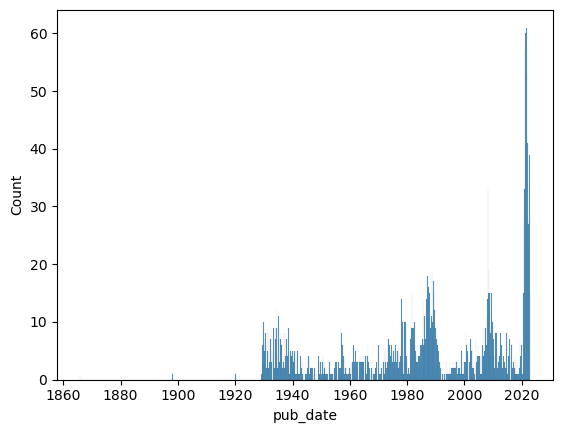

In [148]:
# Make a histogram of the publication dates, setting each month as a bin
# Use seaborn
sns.histplot(full_df['pub_date'], bins=full_df['pub_date'].dt.to_period('M').unique().shape[0])

Looking at this graph, we see the majority of the articles start around 1930. Trim the data only include entries with publication dates >= 1930

In [149]:
full_df = full_df[full_df['pub_date'] > dt.datetime(1930, 1, 1).astimezone(tz=dt.timezone.utc)]

/var/folders/x0/4wc1x1s934q1t58trc5dtw0h0000gp/T/ipykernel_85513/2191979633.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sns.histplot(full_df['pub_date'], bins=full_df['pub_date'].dt.to_period('M').unique().shape[0])


<Axes: xlabel='pub_date', ylabel='Count'>

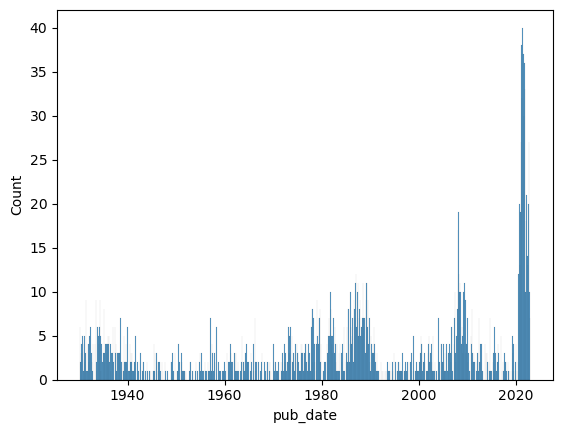

In [150]:
sns.histplot(full_df['pub_date'], bins=full_df['pub_date'].dt.to_period('M').unique().shape[0])

<Axes: xlabel='pub_date', ylabel='word_count'>

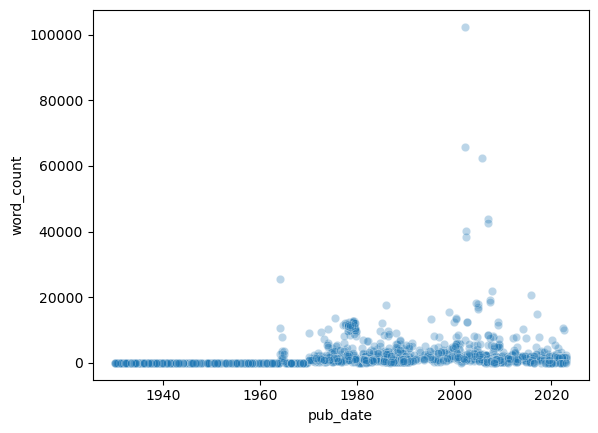

In [151]:
# Do the word counts and publication dates correlate?
sns.scatterplot(data=full_df, x='pub_date', y='word_count', alpha=0.3)

/Users/work/opt/anaconda3/envs/python311/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='pub_date', ylabel='word_count'>

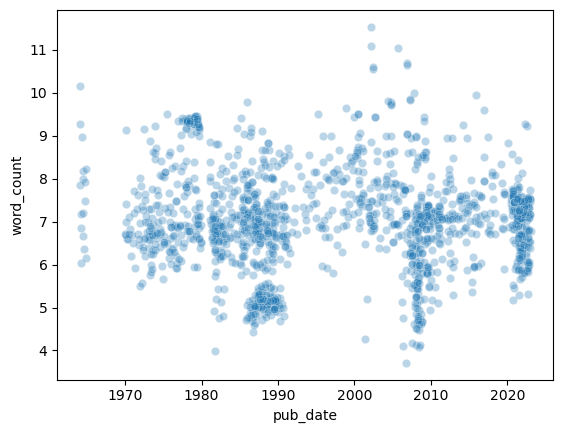

In [152]:
# Use a log scale for the y axis
sns.scatterplot(x=full_df['pub_date'], y=np.log(full_df['word_count']), alpha=0.3)